In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

dataset = pd.read_csv('SPY_data.csv',index_col="date",parse_dates=True)
dataset = dataset.dropna(axis=0, how='all')  #get rid of rows with NaN
dataset = dataset.dropna(axis=1, how='all')  #get rid of cols with NaN
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

In [2]:
sws=100
training_set=pd.DataFrame(dataset)
training_set_scaled = sc.fit_transform(training_set)
X_train = []
y_train = []
for i in range(sws, 5370):
    X_train.append(training_set_scaled[i-sws:i])
    y_train.append(training_set_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))

In [3]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
import pickle

def train_model(name, X_train, y_train):
    regressor = Sequential()
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 5)))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(LSTM(units = 50))
    regressor.add(Dense(units = 5))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])

    #history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_split = 0.2)
    history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
    regressor.save(name+'.h5')
    with open(name, 'wb') as f:
        pickle.dump(history, f)
    return regressor, history

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 5)))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(LSTM(units = 50))
regressor.add(Dense(units = 5))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 50)           11200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 255       
Total params: 72,055
Trainable params: 72,055
Non-trainable params: 0
_________________________________________________________________


In [5]:
import matplotlib.pyplot as plt

def plot_eval_scores(history):
    plt.plot(history.history['mean_squared_error'], '-b', label = 'mse')
    plt.legend(loc='upper left')
    plt.title('Model MSE')
    plt.ylabel('Acc')
    plt.xlabel('Epoch')
    plt.show()

    plt.clf()

    plt.plot(history.history['loss'], '-b', label = 'loss')
    #plt.plot(history.history['val_loss'], '-r', label = 'val_loss')
    plt.legend(loc='upper left')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

In [6]:
# Making the predictions and visualising the results
from sklearn.metrics import mean_squared_error
import math

In [7]:
#regressor, history = train_model('SPY_LSTM_sws100_all', X_train, y_train)
regressor = load_model('SPY_LSTM_sws100_all.h5')

In [8]:
# history = pickle.load(open("SPY_LSTM_sws100_all", "rb" ))
# plot_eval_scores(history)

In [9]:
inputs = dataset.values.reshape(-1,5)
inputs = sc.transform(inputs)
X_test = []
X_test.append(inputs[len(dataset)-sws:len(dataset)+1])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price = pd.DataFrame(predicted_stock_price).astype(float).round(2)
predicted_stock_price.columns = ['Open', 'High', 'Low', 'Close', 'Vol']
print('Next day prices\n'.center(50))
print(predicted_stock_price)

                 Next day prices
                 
     Open    High     Low   Close         Vol
0  282.83  286.31  281.03  283.35  96193272.0


In [10]:
inputs = dataset.values.reshape(-1,5)
inputs = sc.transform(inputs)
X_test = []  #3D array. num rows = num obs 5/8 onwards, 100 obsv each day, 5 vals for each obsv
for i in range(5370, len(inputs)):
     X_test.append(inputs[i-sws:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))

In [11]:
def get_RMSE(y_type, k):
    testScore = math.sqrt(mean_squared_error(real_stock_price[:,k], predicted_stock_price[y_type].values))
    print('Root Mean Square Error for ' +y_type+ ': ', testScore, '\n')

def plot_results(y_type, k):
    col_name = str(k+1)+'. '+y_type
    training_set=dataset[col_name]
    training_set=pd.DataFrame(training_set)
    training_set_scaled = sc.fit_transform(training_set)
    
    regressor = load_model('SPY_LSTM_4000_5348_sws100_' +y_type+ '.h5')
    sws=100

    old_X_test = X_test[:,:,k]
    old_X_test = np.reshape(old_X_test, (old_X_test.shape[0], old_X_test.shape[1], 1))
    old_predicted_stock_price = regressor.predict(old_X_test)
    old_predicted_stock_price = sc.inverse_transform(old_predicted_stock_price)
    old_predicted_stock_price = pd.DataFrame(old_predicted_stock_price)
    print(old_predicted_stock_price)
    testScore = math.sqrt(mean_squared_error(real_stock_price[:,k], old_predicted_stock_price.values))
    print('Old RMSE LB 100 ' +y_type+ ': ', testScore, '\n')
    
    if k > 1:
        regressor = load_model('SPY_LSTM_4000_5348_sws150_' +y_type+ '.h5')
        sws=150
        # below is equivalent even though uses same sc transform as the one in the fn
        inputs = dataset[col_name].values.reshape(-1,1)
        inputs = sc.transform(inputs)
        old_X_test = []  #3D array. num rows = num obs 5/8 onwards, 100 obsv each day, 5 vals for each obsv
        for i in range(5370, len(inputs)):
             old_X_test.append(inputs[i-sws:i])
        old_X_test = np.array(old_X_test)
        old_X_test = np.reshape(old_X_test, (old_X_test.shape[0], old_X_test.shape[1], 1))
        old_predicted_stock_price_sws150 = regressor.predict(old_X_test)
        old_predicted_stock_price_sws150 = sc.inverse_transform(old_predicted_stock_price_sws150)
        old_predicted_stock_price_sws150 = pd.DataFrame(old_predicted_stock_price_sws150)
        print(old_predicted_stock_price_sws150)
        testScore = math.sqrt(mean_squared_error(real_stock_price[:,k], old_predicted_stock_price_sws150.values))
        print('Old RMSE LB 150' +y_type+ ': ', testScore, '\n')
    
    Y_type = y_type.capitalize()
    x_dates = ['5/8','5/9','5/10', '5/13', '5/14']
    plt.plot(x_dates, real_stock_price[:,k], marker='o', color = 'red', label = 'Real SPY')
    plt.plot(x_dates, predicted_stock_price[Y_type].values, marker='o', color = 'blue', label = 'Predicted SPY')
    if k > 1:
        plt.plot(x_dates, old_predicted_stock_price.values, marker='o', color = 'green', label = 'Old Pred SPY, LB 100')
        plt.plot(x_dates, old_predicted_stock_price_sws150.values, marker='o', color = 'yellow', label = 'Old Pred SPY, LB 150')
    else:
        plt.plot(x_dates, old_predicted_stock_price.values, marker='o', color = 'green', label = 'Old Pred SPY')
    plt.title(Y_type + ' Stock Price Prediction 5/8 - 5/14')
    #plt.xticks(rotation='vertical')
    plt.ylabel('Stock Price')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()  #must have .show() and .clf() else all will show on same plot
    plt.clf()

In [12]:
# base = datetime.datetime.strptime('May 8 2019', '%b %d %Y')
# date_list = [base + datetime.timedelta(days=x) for x in range(0, 3)]
# date_dict = {i:date.date() for i, date in enumerate(date_list)}
date_list = ['5/8','5/9','5/10', '5/13', '5/14']
date_dict = {i:date for i,date in enumerate(date_list)}

predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price = pd.DataFrame(predicted_stock_price).astype(float).round(2)
predicted_stock_price.columns = ['Open', 'High', 'Low', 'Close', 'Vol']
predicted_stock_price = predicted_stock_price.rename(index=date_dict)
print('Predicted\n'.center(50))
print(predicted_stock_price, '\n')
predicted_stock_price.to_excel("pred_prices.xlsx")

real_stock_price = dataset.iloc[5370:,].values
print('Actual\n'.center(50))
print(dataset.iloc[5370:,], '\n')
rsp = pd.DataFrame (real_stock_price)
rsp.to_excel("actual_prices.xlsx")

                    Predicted
                    
        Open    High     Low   Close          Vol
5/8   286.47  289.69  283.92  286.01  122165504.0
5/9   286.83  290.04  284.85  286.92  101676448.0
5/10  285.61  288.83  283.23  285.40  115419400.0
5/13  286.02  289.26  283.94  286.05  107234776.0
5/14  280.36  284.05  277.23  279.87  142808592.0 

                     Actual
                      
            1. open  2. high  3. low  4. close    5. volume
date                                                       
2019-05-08   287.53   289.43  286.87    287.53   91568287.0
2019-05-09   285.23   287.33  283.30    286.66  103120377.0
2019-05-10   285.62   288.94  282.30    288.10  101703031.0
2019-05-13   282.42   283.49  279.93    280.86  127198400.0
2019-05-14   281.99   285.10  281.85    283.40   73354735.0 



In [13]:
get_RMSE('Open', 0)
get_RMSE('High', 1)
get_RMSE('Low', 2)
get_RMSE('Close', 3)

Root Mean Square Error for Open:  1.9647188093973915 

Root Mean Square Error for High:  2.8920304286089387 

Root Mean Square Error for Low:  3.14306856431736 

Root Mean Square Error for Close:  3.1325708292072174 



            0
0  290.038544
1  288.356262
2  286.097809
3  286.031311
4  283.799347
Old RMSE LB 100 open:  2.553817215729225 



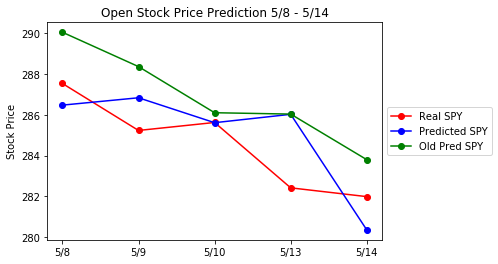

            0
0  293.249939
1  291.246765
2  289.295197
3  289.393433
4  287.374512
Old RMSE LB 100 high:  3.743876804408786 



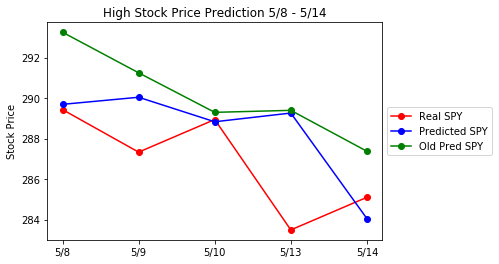

            0
0  282.856537
1  283.642426
2  280.528717
3  279.606018
4  277.384735
Old RMSE LB 100 low:  2.807352480810415 

            0
0  285.624969
1  285.242432
2  283.445435
3  281.716309
4  279.736938
Old RMSE LB 150low:  1.690626476606 



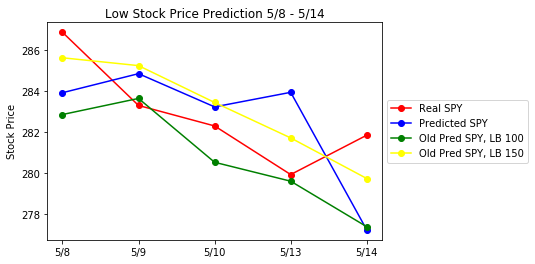

            0
0  286.179138
1  283.380432
2  281.350250
3  281.550507
4  280.179047
Old RMSE LB 100 close:  3.714588935383079 

            0
0  295.356262
1  292.339172
2  290.517090
3  291.147339
4  289.200378
Old RMSE LB 150close:  6.911142205711106 



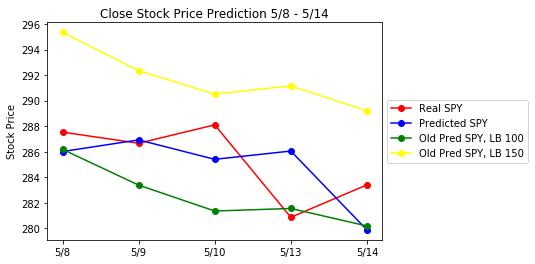

<Figure size 432x288 with 0 Axes>

In [14]:
plot_results('open', 0)
plot_results('high', 1)
plot_results('low', 2)
plot_results('close', 3)